# Tutorial on Riemannian Wasserstein Flow Matching

Here we present a tutorial on how to run RWFM for point-cloud generation on spherical manifolds.

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [4]:
import jax
import numpy as np
import matplotlib.pyplot as plt
import skimage

from tqdm import tqdm

In [6]:
from src.wassersteinflowmatching.riemannian_wasserstein import RiemannianWassersteinFlowMatching

# Load MNIST Images

In [5]:
# add RiemannianMatchingNotebooks/ShapeNetDatasets.py to path

import sys
sys.path.append('/homefs/home/havivd/RiemannianMatchingNotebooks')

In [6]:
from ShapeNetDatasets import get_all_point_clouds
pc_train, pc_test, pc_val = get_all_point_clouds(category='airplane')

# Convert to 2D

In [7]:
# convert to 2d point clouds

def project_to_2d(pc, eps = 0.07, split_axis=1):
    z_mean = np.mean(pc[:, split_axis])

    # take all points with z in z_mean +- eps
    mask = (pc[:, split_axis] > z_mean - eps) & (pc[:, split_axis] < z_mean + eps)
    pc_2d = pc[mask][:, [i for i in range(pc.shape[1]) if i != split_axis]]
    return pc_2d

pc_train_2d = [project_to_2d(pc) for pc in pc_train]
pc_test_2d = [project_to_2d(pc) for pc in pc_test]
pc_val_2d = [project_to_2d(pc) for pc in pc_val]

## Visualize

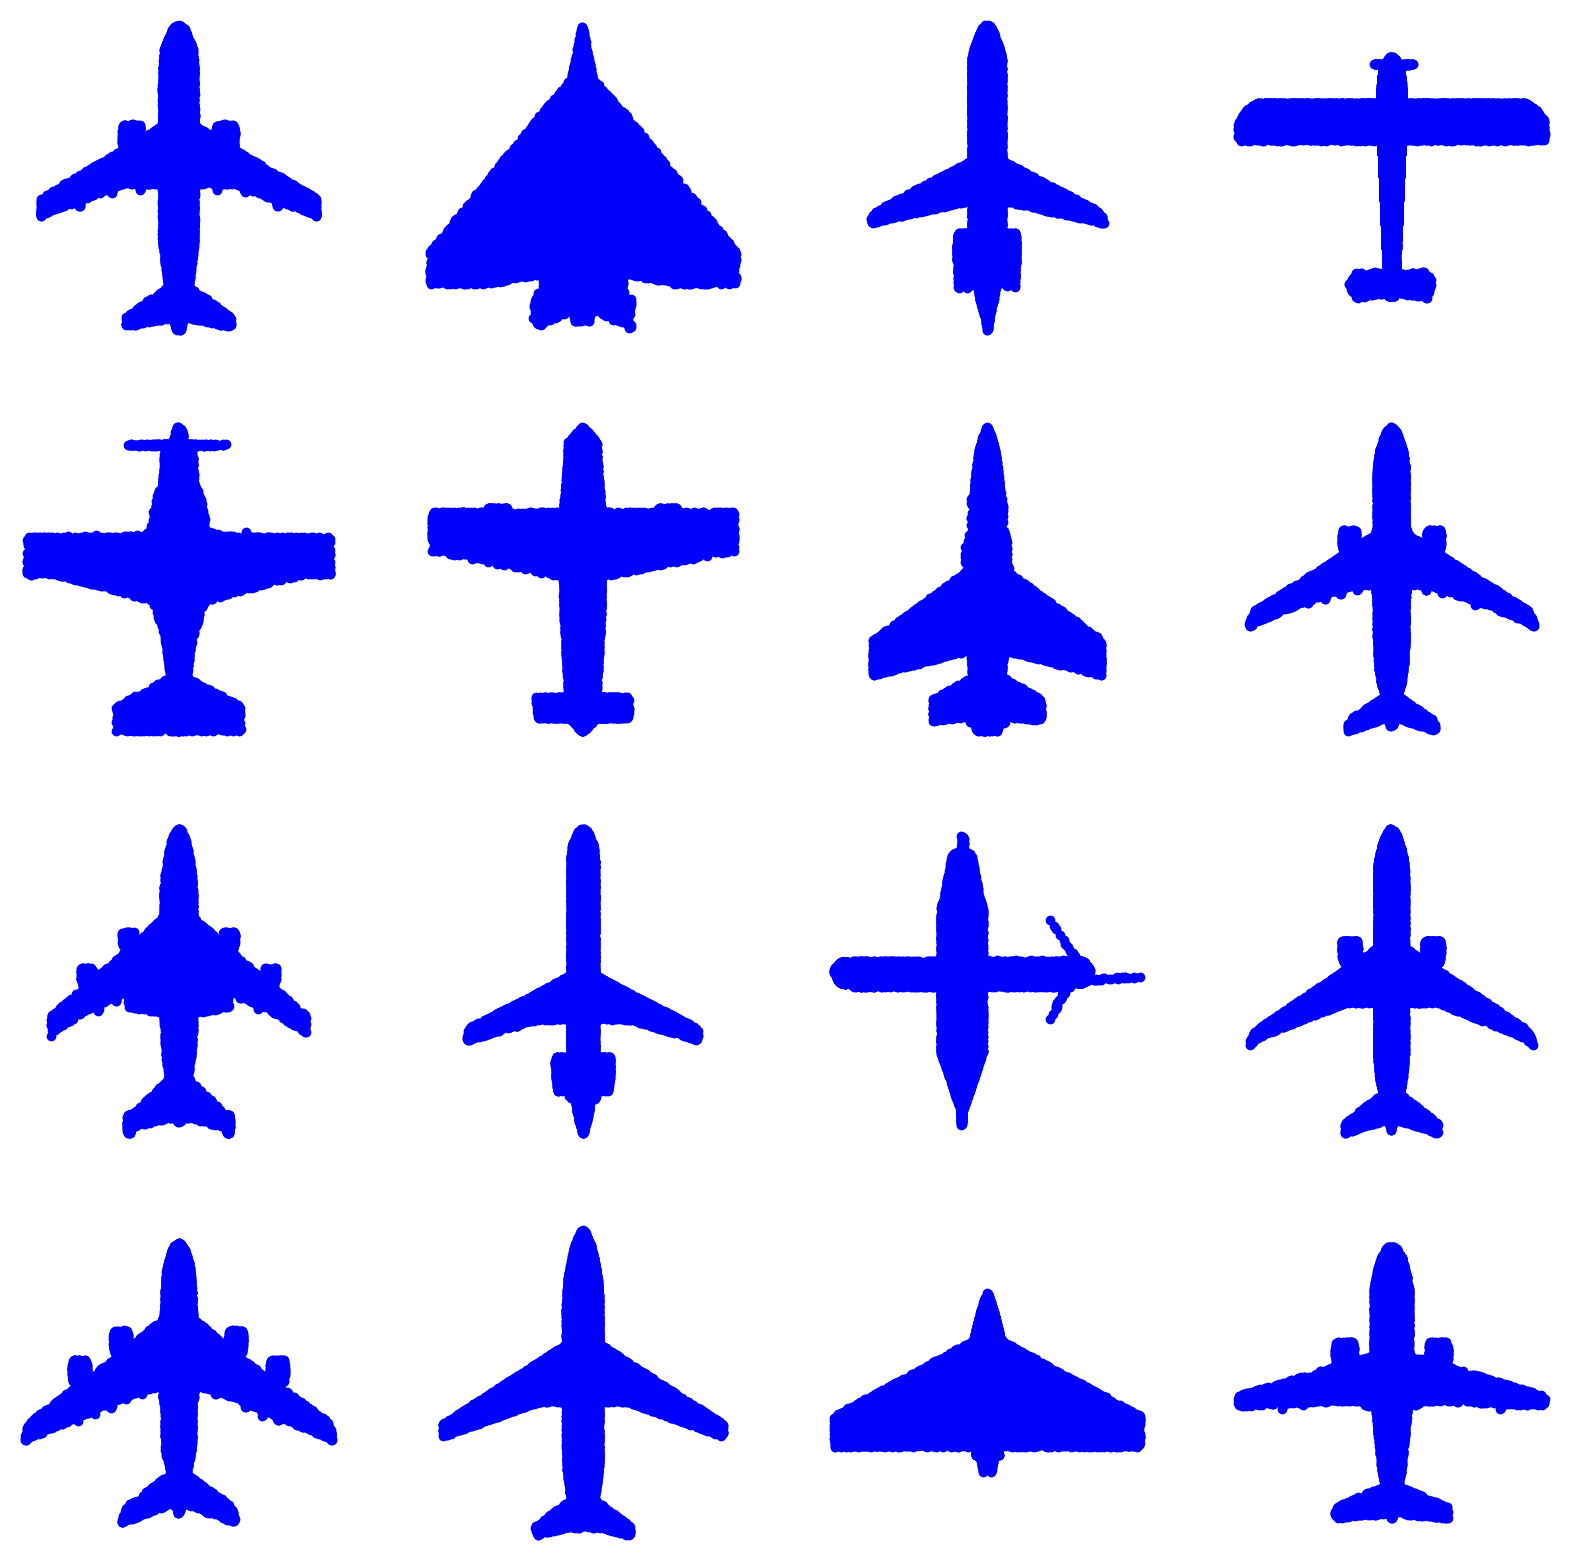

In [8]:
fig = plt.figure(figsize=(20, 20)) 
for ind in range(16):
    ax = fig.add_subplot(4, 4, 1+ind)


    i = np.random.choice(np.arange(len(pc_train_2d)))
    points = pc_train_2d[i]


    ax.scatter(points[:, 0], 
               -points[:, 1],  c = 'blue')




    ax.axis('off')

    
    plt.gca().set_aspect('equal')

# plt.tight_layout()
plt.show()


# Convert to Hyperbolic

In [9]:


def pc_to_hyperbolic(pc, scale = 1.0):
    """
    Lifts a Euclidean point cloud to the Hyperboloid (Lorentz model).
    
    It maps a point p in R^d to x in R^(d+1) such that:
    x = (sqrt(1 + ||p||^2), p)
    
    This ensures <x, x>_L = -1 and x[0] > 0.
    
    :param pc: Input point cloud of shape (N, D)
    :return: Hyperbolic point cloud of shape (N, D+1)
    """
    # 1. Calculate the squared Euclidean norm of the spatial coordinates
    # Shape: (N, 1)

    pc = pc * scale

    spatial_norm_sq = np.sum(pc**2, axis=-1, keepdims=True)
    
    # 2. Solve for the time component (index 0)
    # The constraint is: -x0^2 + ||x_space||^2 = -1
    # Therefore: x0 = sqrt(1 + ||x_space||^2)
    x0 = np.sqrt(1.0 + spatial_norm_sq)
    
    # 3. Concatenate time component as the first axis (standard Lorentz convention)
    # Shape: (N, D+1)
    return np.concatenate([x0, pc], axis=-1)

pc_train_hyperbolic = [pc_to_hyperbolic(pc, scale=2) for pc in pc_train_2d]
pc_test_hyperbolic = [pc_to_hyperbolic(pc, scale=2) for pc in pc_test_2d]
pc_val_hyperbolic = [pc_to_hyperbolic(pc, scale=2) for pc in pc_val_2d]

## Visualize

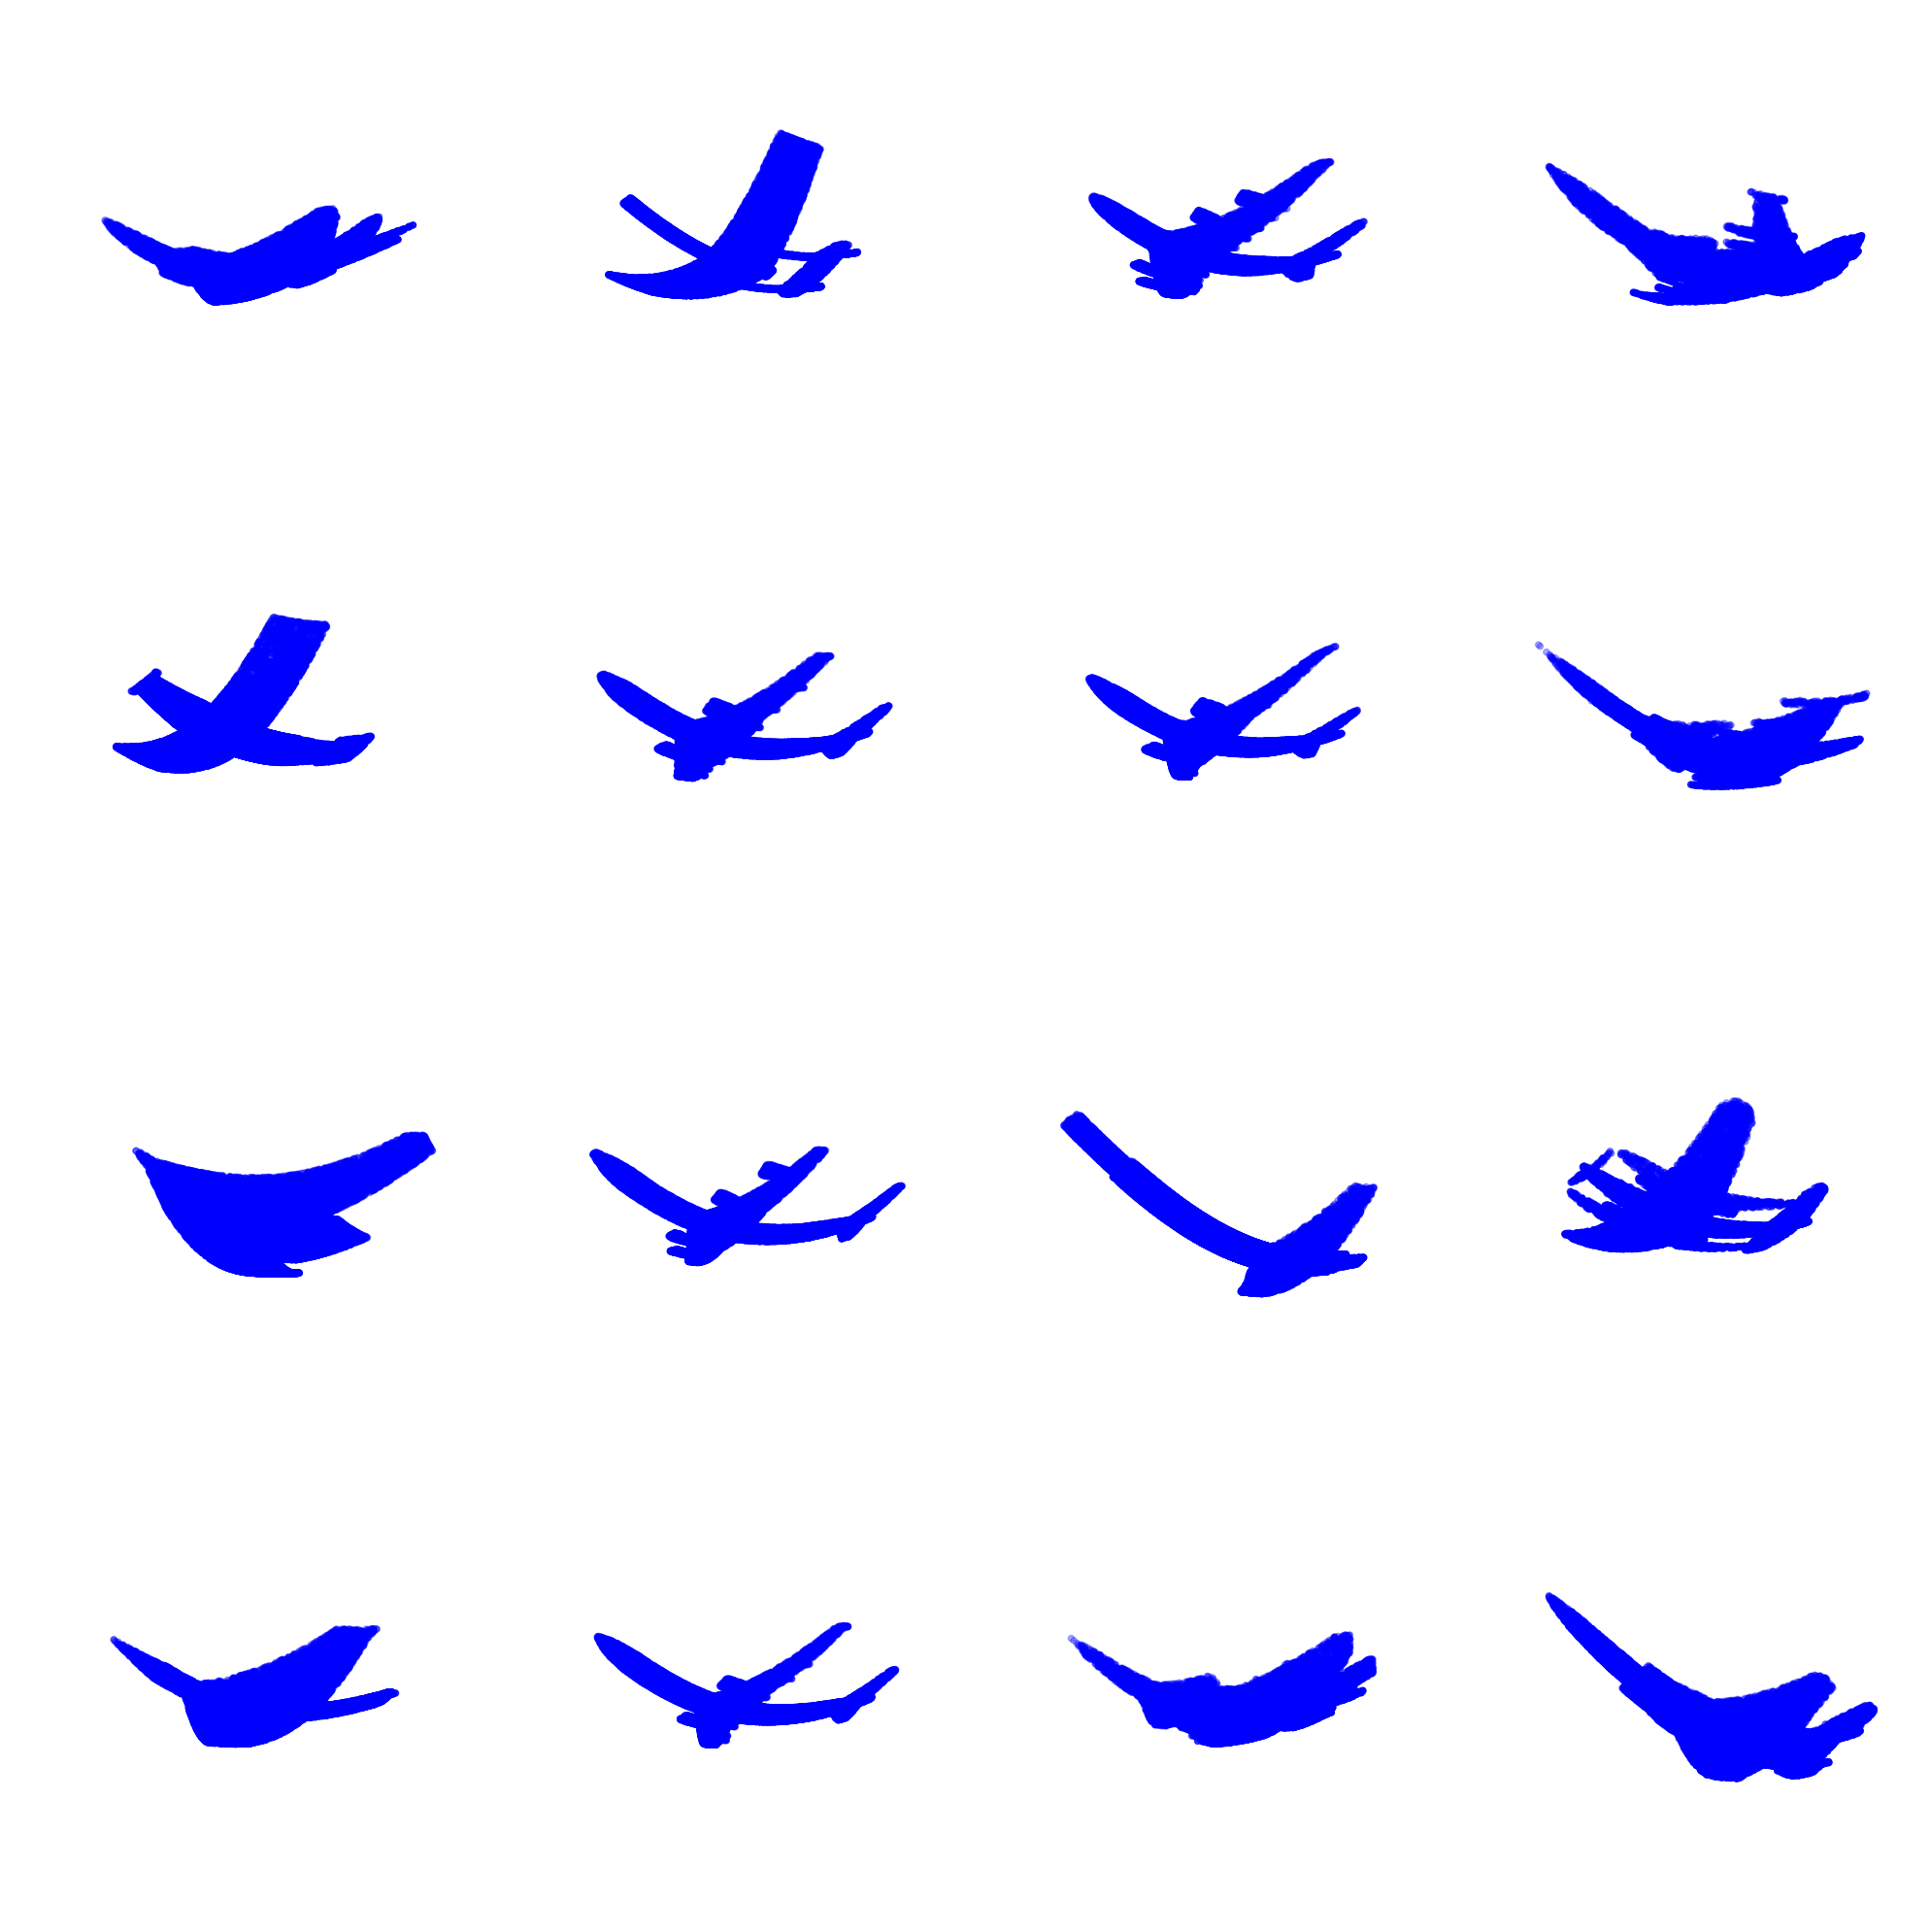

In [10]:
fig = plt.figure(figsize=(20, 20)) 
for ind in range(16):
    ax = fig.add_subplot(4, 4, 1+ind, projection='3d')


    i = np.random.choice(np.arange(len(pc_train_hyperbolic)))
    points = pc_train_hyperbolic[i]


    ax.scatter(points[:, 2], 
               -points[:, 1], 
               points[:, 0],  c = 'blue', depthshade=True)




    ax.axis('off')

    
    plt.gca().set_aspect('equal')

plt.tight_layout()
plt.show()


# Run Riemannian Wasserstein Flow Matching

In [11]:
from wassersteinflowmatching.riemannian_wasserstein import RiemannianWassersteinFlowMatching

In [12]:

class rwfm_config:
    geom: str = 'hyperbolic'
    monge_map: str = 'entropic'
    wasserstein_eps: float = 0.0005
    wasserstein_lse: bool = True
    num_sinkhorn_iters: int = -1
    mini_batch_ot_mode: bool = True
    mini_batch_ot_solver: str = 'chamfer'
    mini_batch_ot_num_iter: int = -1
    minibatch_ot_eps: float = 0.0005
    minibatch_ot_lse: bool = True
    noise_type: str = 'ambient_gaussian'
    noise_geom: str = 'hyperbolic'
    scaling: str = 'None'
    factor: float = 1.0
    embedding_dim: int = 512
    num_layers: int = 6
    num_heads: int = 4
    dropout_rate: float = 0.1
    mlp_hidden_dim: int = 512
    cfg: bool = False
    p_cfg_null: float = 0.0
    w_cfg: float = 1.0
    normalized_condition: bool = False

 


FlowMatchingModel = RiemannianWassersteinFlowMatching(point_clouds = pc_train_hyperbolic, 
                                                      config = rwfm_config)

Initializing WassersteinFlowMatching
Using hyperbolic geometry
Projecting point clouds to geometry (with cpu)...


100%|███████████████████████████████████████████████████████████████| 2832/2832 [00:00<00:00, 10248.32it/s]


Using hyperbolic geometry for noise


W1216 23:09:45.559668  992997 gemm_fusion_autotuner.cc:1160] Compiling 21 configs for gemm_fusion_dot_general.3 on a single thread.


Using ambient_gaussian noise for hyperbolic geometry.
Noise parameters:
  mean: [1.0761716e+00 7.9408678e-04 8.1977174e-02]
  cov_chol_mean: [[ 7.2613873e-02  0.0000000e+00  0.0000000e+00]
 [ 7.3286076e-04  2.2141132e-01  0.0000000e+00]
 [ 1.0644997e-01 -6.1363040e-05  2.5263584e-01]]
  cov_chol_std: [[0.01637316 0.         0.        ]
 [0.01320497 0.05360809 0.        ]
 [0.12328027 0.00730297 0.05345261]]
  noise_df_scale: 1.0
Finding optimal number of Sinkhorn iterations...


W1216 23:09:52.806884  992997 gemm_fusion_autotuner.cc:1160] Compiling 7 configs for gemm_fusion_dot_general.1 on a single thread.
W1216 23:09:55.761849  992997 gemm_fusion_autotuner.cc:1160] Compiling 5 configs for gemm_fusion_dot_general.1 on a single thread.


INFO: Found sufficient convergence (80%) at 740 iterations.
Auto-selected 740 Sinkhorn iterations.
Using entropic map with 740 iterations and 0.0005 epsilon
Chamfer Mini-Batch
Finding optimal number of Sinkhorn iterations for Mini-Batch OT...


W1216 23:10:01.426821  992997 gemm_fusion_autotuner.cc:1160] Compiling 5 configs for gemm_fusion_dot_general.0 on a single thread.


Auto-selected 630 Sinkhorn iterations for Mini-Batch OT.


## Test WFM maps

### Noise Generation

In [13]:
import jax.numpy as jnp
from jax import random

In [14]:
key = random.PRNGKey(0)

In [15]:

K = 64
n = 512
d = 3

key, subkey = random.split(key)
hyperbolic_points = FlowMatchingModel.noise_func((K, n, d), FlowMatchingModel.noise_config, subkey)



W1216 23:10:03.636984  992997 gemm_fusion_autotuner.cc:1160] Compiling 9 configs for gemm_fusion_dot_general.1 on a single thread.


###  OT Map

In [16]:
batch_ind = np.random.choice(np.arange(len(pc_train)), size = 16, replace = False)

In [17]:
point_clouds_batch, weights_batch = FlowMatchingModel.point_clouds[batch_ind], FlowMatchingModel.weights[batch_ind]

sample_points = jax.vmap(FlowMatchingModel.sample_single_batch, in_axes=(0, 0, 0, None))

keys = jax.random.split(subkey, batch_ind.shape[0])
point_clouds_batch, weights_batch = sample_points(point_clouds_batch, weights_batch, keys, 512)
                    

In [18]:
subkey_noise, key = random.split(key)
noise_samples = FlowMatchingModel.noise_func(size=point_clouds_batch.shape, 
                                noise_config=FlowMatchingModel.noise_config,
                                key=subkey_noise)
noise_weights = weights_batch

noise_samples = FlowMatchingModel.project_to_geometry(noise_samples)




if FlowMatchingModel.mini_batch_ot_mode:
    # Time minibatch_ot operation
    minibatch_key, key = random.split(key)
    noise_ind = FlowMatchingModel.minibatch_ot(point_clouds_batch, weights_batch, noise_samples, noise_weights, key=minibatch_key)[0]
    noise_samples = noise_samples[noise_ind]
    if(FlowMatchingModel.monge_map != 'rounded_matching'):
        noise_weights = noise_weights[noise_ind]

W1216 23:10:08.210780  992997 gemm_fusion_autotuner.cc:1160] Compiling 9 configs for gemm_fusion_dot_general.1 on a single thread.
W1216 23:10:10.033043  992997 gemm_fusion_autotuner.cc:1160] Compiling 5 configs for gemm_fusion_dot_general.1 on a single thread.


In [19]:
subkey_t, key = random.split(key)

interpolates_time = random.uniform(subkey_t, (point_clouds_batch.shape[0],), minval=0.0, maxval=1.0)

# Time transport_plan_jit operation
ot_matrix = FlowMatchingModel.transport_plan_jit([noise_samples, noise_weights], 
                                    [point_clouds_batch, weights_batch])[0]

if FlowMatchingModel.monge_map == 'sample':
    # For sampling assignment, we need the random keys
    assigned_points = FlowMatchingModel.sample_map_jit(ot_matrix, point_clouds_batch, random.split(key, point_clouds_batch.shape[0]))
elif FlowMatchingModel.monge_map == 'random':
    assigned_points = FlowMatchingModel.sample_map_jit(ot_matrix, point_clouds_batch, random.split(key, point_clouds_batch.shape[0]))
elif(FlowMatchingModel.monge_map == 'entropic'):
    assigned_points = FlowMatchingModel.sample_map_jit(ot_matrix, noise_samples, point_clouds_batch)
else:
    # For other methods (rounded_matching and barycentric), we don't need keys
    assigned_points = FlowMatchingModel.sample_map_jit(ot_matrix, point_clouds_batch)

W1216 23:10:13.927846  992997 gemm_fusion_autotuner.cc:1160] Compiling 8 configs for gemm_fusion_dot_general.1 on a single thread.


In [20]:
point_cloud_interpolates = FlowMatchingModel.interpolant_vmap(noise_samples, assigned_points, 1-interpolates_time)
point_cloud_velocity = FlowMatchingModel.interpolant_velocity_vmap(noise_samples, assigned_points, 1-interpolates_time)



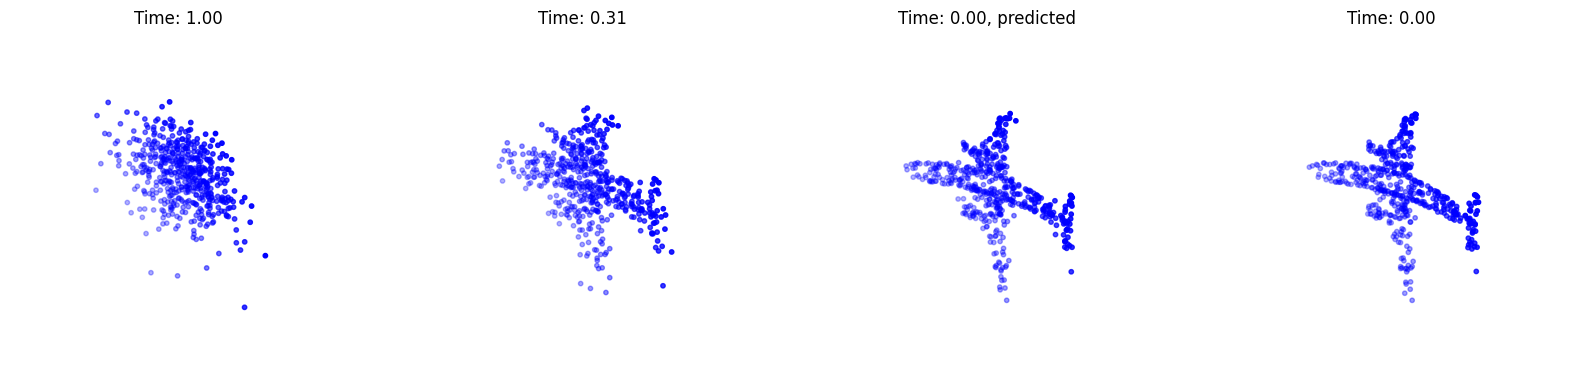

In [21]:
ind_plot = np.random.choice(np.arange(point_cloud_interpolates.shape[0]))


point_cloud_end_point = jnp.squeeze(FlowMatchingModel.exponential_map_vmap(point_cloud_interpolates[ind_plot][None, :, :], 
                                                                           point_cloud_velocity[ind_plot][None, :, :], 
                                                                           interpolates_time[ind_plot]))


fig = plt.figure(figsize=(20, 5))

ax = fig.add_subplot(1, 4, 1, projection='3d')

points = noise_samples[ind_plot][noise_weights[ind_plot]>0]
points = jnp.where(points > jnp.pi, points - 2 * jnp.pi, points)

ax.scatter(points[:, 2], 
            -points[:, 0], 
            points[:, 1],  c = 'blue', depthshade=True, zorder = 2, s = 10)
ax.axis('off')
plt.title(f'Time: {1:.2f}')
plt.gca().set_aspect('equal')


ax = fig.add_subplot(1, 4, 2, projection='3d')

points = point_cloud_interpolates[ind_plot][noise_weights[ind_plot]>0]
points = jnp.where(points > jnp.pi, points - 2 * jnp.pi, points)

ax.scatter(points[:, 2], 
            -points[:, 0], 
            points[:, 1],  c = 'blue', depthshade=True, zorder = 2, s = 10)
ax.axis('off')
plt.title(f'Time: {interpolates_time[ind_plot]:.2f}')
plt.gca().set_aspect('equal')

ax = fig.add_subplot(1, 4, 3, projection='3d')
points = point_cloud_end_point[noise_weights[ind_plot]>0]
points = jnp.where(points > jnp.pi, points - 2 * jnp.pi, points)

ax.scatter(points[:, 2], 
            -points[:, 0], 
            points[:, 1],  c = 'blue', depthshade=True, zorder = 2, s = 10)
ax.axis('off')
plt.title(f'Time: {0:.2f}, predicted')
plt.gca().set_aspect('equal')


ax = fig.add_subplot(1, 4, 4, projection='3d')

points = point_clouds_batch[ind_plot][weights_batch[ind_plot]>0]
points = jnp.where(points > jnp.pi, points - 2 * jnp.pi, points)

ax.scatter(points[:, 2], 
            -points[:, 0], 
            points[:, 1],  c = 'blue', depthshade=True, zorder = 2, s = 10)
ax.axis('off')
plt.title(f'Time: {0:.2f}')
plt.gca().set_aspect('equal')
plt.show()

## Train Model

Train Model & Plot loss curve

In [ ]:

FlowMatchingModel.train(batch_size = 32, 
                        shape_sample = 1024,
                        training_steps = 500000, 
                        decay_steps = 5000)

W1216 23:10:22.691376  992997 gemm_fusion_autotuner.cc:1160] Compiling 4 configs for gemm_fusion_dot_general.1 on a single thread.
W1216 23:10:23.614725  992997 gemm_fusion_autotuner.cc:1160] Compiling 8 configs for gemm_fusion_dot on a single thread.
W1216 23:10:24.741378  992997 gemm_fusion_autotuner.cc:1160] Compiling 3 configs for gemm_fusion_dot_general.1 on a single thread.
W1216 23:10:25.522770  992997 gemm_fusion_autotuner.cc:1160] Compiling 13 configs for gemm_fusion_dot on a single thread.
W1216 23:10:27.200867  992997 gemm_fusion_autotuner.cc:1160] Compiling 12 configs for gemm_fusion_dot.1 on a single thread.
W1216 23:10:28.427063  992997 gemm_fusion_autotuner.cc:1160] Compiling 8 configs for gemm_fusion_dot.2 on a single thread.
W1216 23:10:29.058280  992997 gemm_fusion_autotuner.cc:1160] Compiling 13 configs for gemm_fusion_dot on a single thread.
W1216 23:10:30.620354  992997 gemm_fusion_autotuner.cc:1160] Compiling 13 configs for gemm_fusion_dot on a single thread.
W121

Sampling 1024 points from each point cloud


: 3.704e-02:   0%|                                                  | 57/500000 [02:26<29:07:05,  4.77it/s]


Training interrupted by user. The model state has been saved.


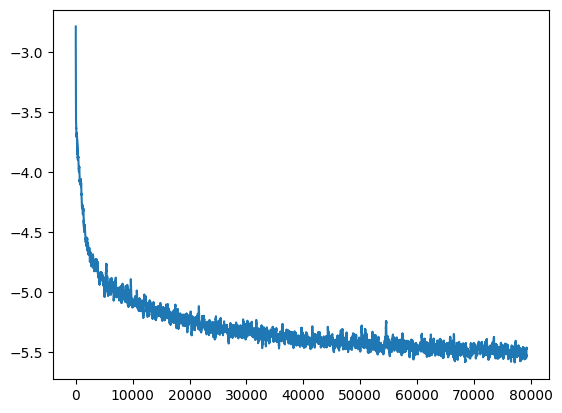

In [ ]:
loss_smooth = np.convolve(np.log(FlowMatchingModel.losses), np.ones(100)/100, mode='valid')
plt.plot(loss_smooth)

# Generate Samples

Set Initial Key

In [ ]:
key = jax.random.PRNGKey(0)

Run Flow for 1000 timesteps

In [ ]:

subkey,key = jax.random.split(key)
generated_samples, sample_weights = FlowMatchingModel.generate_samples(num_samples = 16,
                                                            timesteps = 1000,
                                                            size = 1024,
                                                            key = subkey)
generated_samples = generated_samples[-1]

W1217 02:59:25.663809  992997 gemm_fusion_autotuner.cc:1160] Compiling 9 configs for gemm_fusion_dot_general.1 on a single thread.
W1217 02:59:27.894966  992997 gemm_fusion_autotuner.cc:1163] Compiling 169 configs for 9 fusions on a single thread.


Plot resulting point clouds

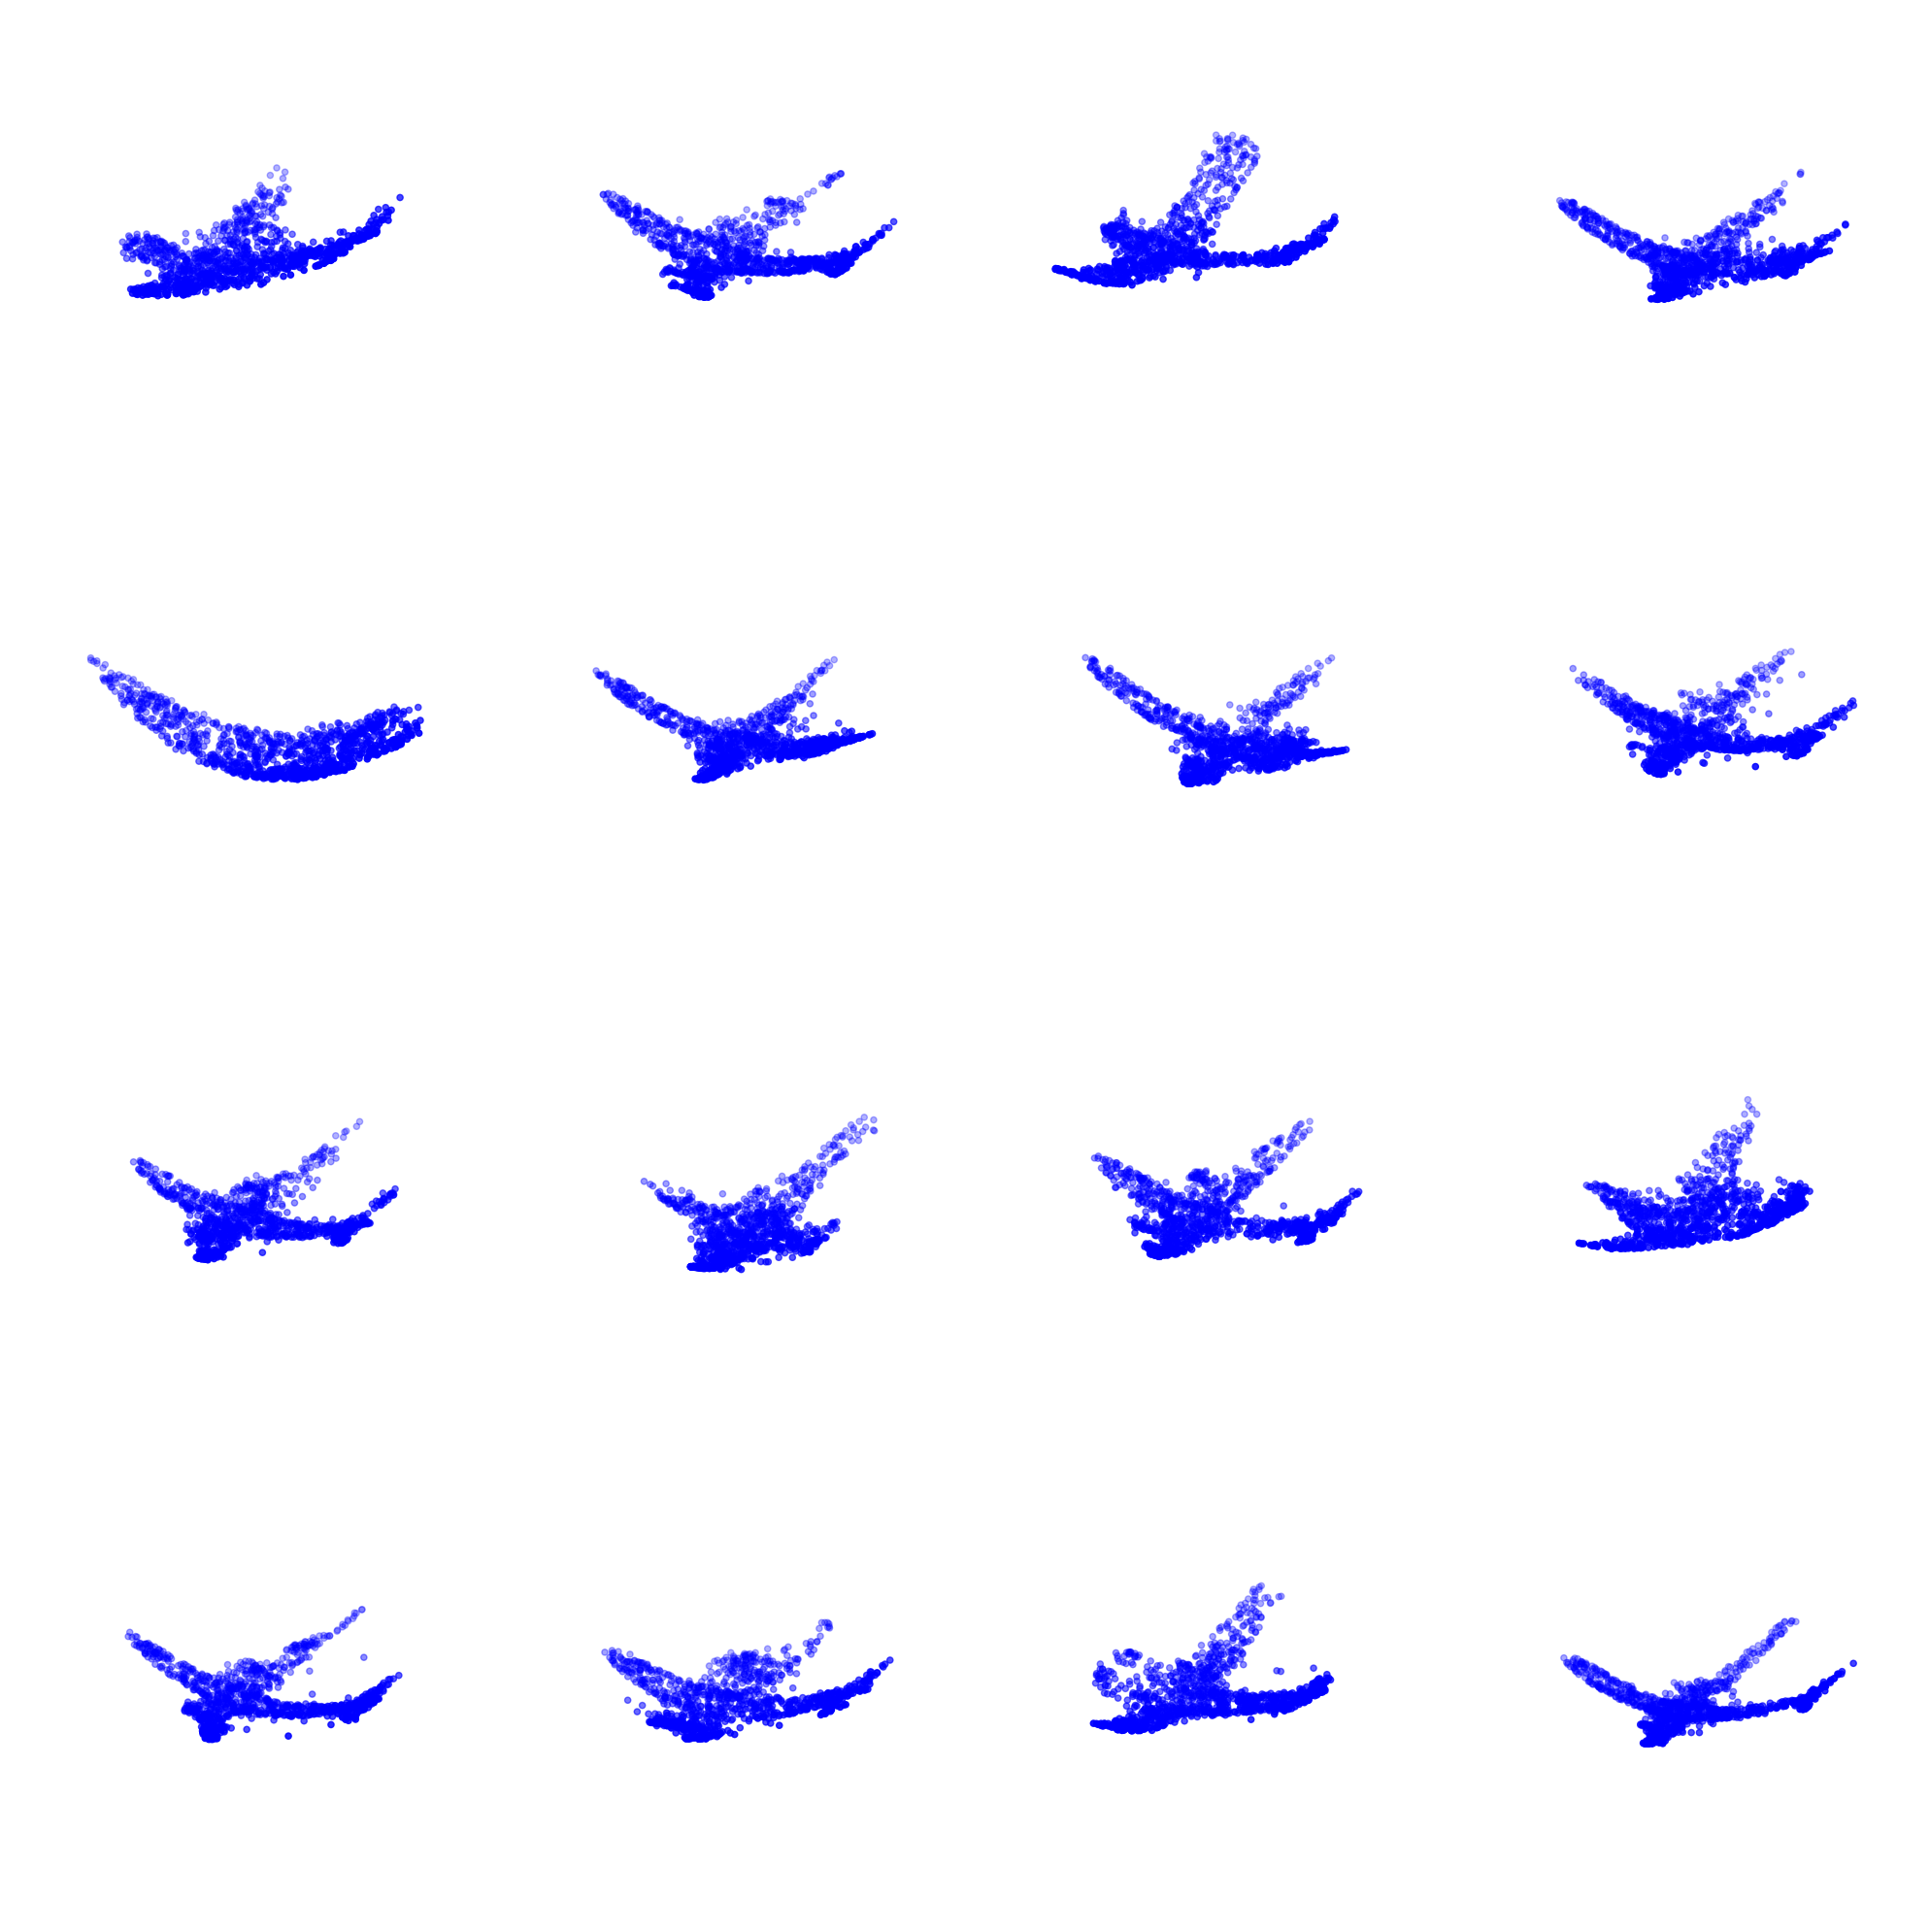

In [ ]:
fig = plt.figure(figsize=(20, 20)) 
for ind in range(16):
    ax = fig.add_subplot(4, 4, 1+ind, projection='3d')


    points = generated_samples[ind]


    ax.scatter(points[:, 2], 
               -points[:, 1], 
               points[:, 0],  c = 'blue', depthshade=True)




    ax.axis('off')

    
    plt.gca().set_aspect('equal')

plt.tight_layout()
plt.show()
